# Emojify! 😊
Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that. 
Rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

We'll implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, you need to remember that ❤️  is the "heart" symbol rather than the "love" symbol. 
    * In other words, you'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.
* You can make a more flexible emoji interface by using word vectors!
* When using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

## Packages

In [1]:
import numpy as np
from utils.emoji_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset EMOJISET

We have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="images/notebook_utils/data_set.png" style="width:700px;height:300px;">

In [2]:
X_train, Y_train = read_csv('datasets/emoji/train_emoji.csv')
X_test, Y_test = read_csv('datasets/emoji/tesss.csv')

In [3]:
maxLen = len(max(X_train, key=len).split())

Run the following cell to print sentences from X_train and corresponding labels from Y_train. 
* Change `idx` to see different examples. 
* Note that due to the font used by iPython notebook, the heart emoji may be colored black rather than red.

In [4]:
for idx in range(20):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾
she did not answer my text  😞
Your stupidity has no limit 😞
how many points did he score ⚾
my algorithm performs poorly 😞
I got approved 😄
Stop shouting at me 😞
Sounds like a fun plan ha ha 😄
no one likes him 😞
the game just finished ⚾
I will celebrate soon 😄


## Overview of the Model
#### Inputs and Outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you"). 
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

#### One-hot Encoding
* To get your labels into a format suitable for training a softmax classifier, convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$, 
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`: 
    


In [5]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

Now, see what `convert_to_one_hot()` did. Feel free to change `idx` to print out different values. 

In [6]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


## Implementing Emojifier

As shown in Figure 2 (above), the first step is to:
* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors. 

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('datasets/emoji/glove.6B.50d.txt')

We've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.

Run the following cell to check if it works:

In [8]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


### Sentence to Average
1. Convert every sentence to lower-case, then split the sentence into a list of words. 
2. For each word in the sentence, access its GloVe representation.

In [9]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Get a valid word contained in the word_to_vec_map. 
    any_word = list(word_to_vec_map.keys())[0]
    
    # Split sentence into list of lower case words
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(word_to_vec_map['a'].shape)
    
    # Initialize count to 0
    count = 0
    
    # Average the word vectors. You can loop over the words in the list "words".
    for w in words:
        
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg / count
    
    return avg

## Implement the Model
We now have all the pieces to finish implementing the `model()` function! 
After using `sentence_to_avg()` you need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

* The equations you implemented in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$


In [10]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = list(word_to_vec_map.keys())[0]
        
    # Initialize cost. It is needed during grading
    cost = 0
    
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = np.sum(Y_oh[i] * np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emoji_utils.py

    return pred, W, b

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5, 0, 0, 5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and have drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is surprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))


(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


Run the next cell to train your model and learn the softmax parameters (W, b). **The training process will take about 5 minutes**

In [12]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = -1.643110354841643
Accuracy: 0.42424242424242425
Epoch: 100 --- cost = -0.07189452751102986
Accuracy: 0.9242424242424242
Epoch: 200 --- cost = -0.04355357948900457
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = -0.03489614813571813
Accuracy: 0.9696969696969697
[[3.]
 [2.]
 [3.]
 [0.]
 [4.]
 [0.]
 [3.]
 [2.]
 [3.]
 [1.]
 [3.]
 [3.]
 [1.]
 [3.]
 [2.]
 [3.]
 [2.]
 [3.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [4.]
 [3.]
 [3.]
 [4.]
 [0.]
 [3.]
 [4.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [3.]
 [4.]
 [2.]
 [2.]
 [0.]
 [2.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [4.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [3.]
 [4.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [3.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [4.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [0.]
 [1.]
 [2.]
 [3.]
 [0.]
 [2.]
 [2.]
 [2.]
 [3.]
 [2.]
 [2.]
 [2.]
 [4.]
 [1.]
 [1.]
 [3.]
 [3.]
 [4.]
 [1.]
 [2.]
 [1.]
 [1.]
 [3.]
 

Great! Your model has pretty high accuracy on the training set. Now see how it does on the test set:

In [13]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.875


* Random guessing would have had 20% accuracy, given that there are 5 classes. (1/5 = 20%).
* This is pretty good performance after training on only 127 examples.

#### The Model Matches Emojis to Relevant Words
In the training set, the algorithm saw the sentence 
>"I love you." 

with the label ❤️. 
* You can check that the word "adore" does not appear in the training set. 
* Nonetheless, let's see what happens if you write "I adore you."

In [14]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

#### Confusion Matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    0    0    7    7
All          9    9   18   13    7   56


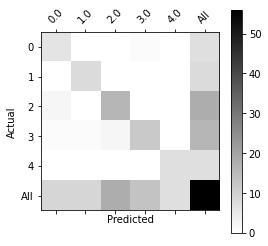

In [15]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

# Making it better
You're going to build an LSTM model that takes word **sequences** as input! This model will be able to account for word ordering. 

## Packages

In [16]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

## Model Overview

<img src="images/notebook_utils/emojifier-v2.png" style="width:700px;height:400px;"> <br>

### Keras and Mini-batching 
You want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the **same length**. 

This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.
    
#### Padding Handles Sequences of Varying Length
* The common solution to handling sequences of **different length** is to use padding.  Specifically:
    * Set a maximum sequence length
    * Pad all sequences to have the same length. 
    
### The embedding layer
In Keras, the embedding matrix is represented as a "layer."

* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * A "dense" vector is the opposite of a sparse vector. It means that most of its values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch. 
    * Using a pretrained embedding.
    
#### Inputs and Outputs to the Embedding Layer

* The `Embedding()` layer's input is an integer matrix of size **(batch size, max input length)**. 
    * This input corresponds to sentences converted into lists of indices (integers).
    * The largest integer (the highest word index) in the input should be no larger than the vocabulary size.
* The embedding layer outputs an array of shape (batch size, max input length, dimension of word vectors).

* The figure shows the propagation of two example sentences through the embedding layer. 
    * Both examples have been zero-padded to a length of `max_len=5`.
    * The word embeddings are 50 units in length.
    * The final dimension of the representation is  `(2,max_len,50)`. 

<img src="images/notebook_utils/embedding1.png" style="width:700px;height:250px;">

In [17]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [18]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
            
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                
                # Increment j to j + 1
                j += 1
            
    return X_indices

Run the following cell to check what `sentences_to_indices()` does, and take a look at your results.

In [19]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


#### Build Embedding Layer

Now you'll build the `Embedding()` layer in Keras, using pre-trained word vectors. 

* The embedding layer takes as input a list of word indices.
    * `sentences_to_indices()` creates these word indices.
* The embedding layer will return the word embeddings for a sentence. 

### Pretrained Embedding Layer
1. Initialize the embedding matrix as a numpy array of zeros.
    * The embedding matrix has a row for each unique word in the vocabulary.
        * There is one additional row to handle "unknown" words.
        * So vocab_size is the number of unique words plus one.
    * Each row will store the vector representation of one word. 
        * For example, one row may be 50 positions long if using GloVe word vectors.
    * In the code below, `emb_dim` represents the length of a word embedding.
2. Fill in each row of the embedding matrix with the vector representation of a word
    * Each word in `word_to_index` is a string.
    * word_to_vec_map is a dictionary where the keys are strings and the values are the word vectors.
3. Define the Keras embedding layer. 
    * Use [Embedding()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). 
    * The input dimension is equal to the vocabulary length (number of unique words plus one).
    * The output dimension is equal to the number of positions in a word embedding.
    * Make this layer's embeddings fixed.
        * If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings.
        * In this case, you don't want the model to modify the word embeddings.
4. Set the embedding weights to be equal to the embedding matrix.
    * Note that this is part of the code is already completed for you and does not need to be modified! 

In [20]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim)
    
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [21]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


## Emojify 2.0
This function builds a Keras graph of the architecture shown in Figure (3). 

* The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. 
* The model outputs a softmax probability vector of shape (`m`, `C = 5`). 

* You may need to use the following Keras layers:
    * [Input()](https://www.tensorflow.org/api_docs/python/tf/keras/Input)
        * Set the `shape` and `dtype` parameters.
        * The inputs are integers, so you can specify the data type as a string, 'int32'.
    * [LSTM()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
        * Set the `units` and `return_sequences` parameters.
    * [Dropout()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
        * Set the `rate` parameter.
    * [Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
        * Set the `units`, 
        * Note that `Dense()` has an `activation` parameter.  For the purposes of passing the autograder, please do not set the activation within `Dense()`.  Use the separate `Activation` layer to do so.
    * [Activation()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation)
        * You can pass in the activation of your choice as a lowercase string.
    * [Model()](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
        * Set `inputs` and `outputs`.

In [22]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape, dtype=np.int32)
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer =  pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    
    # Propagate X through a Dense layer with 5 units
    X = Dense(5, activation='linear')(X)
    
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    return model

Run the following cell to create your model and check its summary. 

* Because all sentences in the dataset are less than 10 words, `max_len = 10` was chosen.  
* You should see that your architecture uses 20,223,927 parameters, of which 20,000,050 (the word embeddings) are non-trainable, with the remaining 223,877 being trainable. 
* Because your vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [23]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics you want to use. Compile your model using categorical_crossentropy loss, adam optimizer and ['accuracy'] metrics:

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model

In [25]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on `X_train_indices` and `Y_train_oh`, using `epochs = 100` and `batch_size = 32`.

In [29]:
model.fit(X_train_indices, Y_train_oh, epochs = 100, batch_size = 32, shuffle=True)

Epoch 1/100
5/5 [==============================] - 1s 142ms/step - loss: 6.9732e-04 - accuracy: 1.0000
Epoch 2/100
5/5 [==============================] - 1s 150ms/step - loss: 7.8155e-04 - accuracy: 1.0000
Epoch 3/100
5/5 [==============================] - 1s 146ms/step - loss: 6.7024e-04 - accuracy: 1.0000
Epoch 4/100
5/5 [==============================] - 1s 148ms/step - loss: 6.8292e-04 - accuracy: 1.0000
Epoch 5/100
5/5 [==============================] - 1s 144ms/step - loss: 7.9856e-04 - accuracy: 1.0000
Epoch 6/100
5/5 [==============================] - 1s 147ms/step - loss: 4.2157e-04 - accuracy: 1.0000
Epoch 7/100
5/5 [==============================] - 1s 149ms/step - loss: 5.3217e-04 - accuracy: 1.0000
Epoch 8/100
5/5 [==============================] - 1s 148ms/step - loss: 5.5313e-04 - accuracy: 1.0000
Epoch 9/100
5/5 [==============================] - 1s 152ms/step - loss: 5.1787e-04 - accuracy: 1.0000
Epoch 10/100
5/5 [==============================] - 1s 151ms/step - loss:

5/5 [==============================] - 1s 139ms/step - loss: 2.6000e-04 - accuracy: 1.0000
Epoch 80/100
5/5 [==============================] - 1s 153ms/step - loss: 1.8190e-04 - accuracy: 1.0000
Epoch 81/100
5/5 [==============================] - 1s 148ms/step - loss: 1.9613e-04 - accuracy: 1.0000
Epoch 82/100
5/5 [==============================] - 1s 145ms/step - loss: 2.2437e-04 - accuracy: 1.0000
Epoch 83/100
5/5 [==============================] - 1s 143ms/step - loss: 2.0839e-04 - accuracy: 1.0000
Epoch 84/100
5/5 [==============================] - 1s 150ms/step - loss: 2.4639e-04 - accuracy: 1.0000
Epoch 85/100
5/5 [==============================] - 1s 149ms/step - loss: 2.3306e-04 - accuracy: 1.0000
Epoch 86/100
5/5 [==============================] - 1s 154ms/step - loss: 2.4554e-04 - accuracy: 1.0000
Epoch 87/100
5/5 [==============================] - 1s 147ms/step - loss: 1.7031e-04 - accuracy: 1.0000
Epoch 88/100
5/5 [==============================] - 1s 144ms/step - loss: 2.2

Run the following cell to evaluate your model on the test set: 

In [30]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 4ms/step - loss: 1.5821 - accuracy: 0.7679

Test accuracy =  0.7678571343421936


In [31]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😄 prediction: he is a good friend	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	😞
Expected emoji:😄 prediction: What you did was awesome	😞
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast 😄


Now you can try it on your own example! Write your own sentence below:

In [34]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['Artificial Intelligence is awesome'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

Artificial Intelligence is awesome 😄


* The current model still isn't very robust at understanding negation (such as "not happy")
    * This is because the training set is small and doesn't have a lot of examples of negation. 
    * If the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding more complex sentences. 